In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
if 'init_modules' in globals():
    for m in [x for x in sys.modules.keys() if x not in init_modules]:
        del(sys.modules[m]) 
else:
    init_modules = sys.modules.keys()

import logging
from math import *
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.stats import ortho_group
from scipy.interpolate import griddata
import importlib

np.set_printoptions(precision=2, suppress=False)

logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.DEBUG)

In [2]:
from chemistry import *
from chemistry.modules import shs
from chemistry.utils import linalg
from chemistry.functions import GaussianWrapper
from chemistry.optimization import GradientDescent, delta_strategies, stop_strategies

importlib.reload(shs)
importlib.reload(functions)
importlib.reload(functions)
importlib.reload(optimization)
importlib.reload(stop_strategies)
importlib.reload(delta_strategies)

<module 'chemistry.optimization.delta_strategies' from '/home/george/work/np-complete/study/au/python_chemistry/chemistry/optimization/delta_strategies/__init__.py'>

In [3]:
molecule, struct = functions.Molecule.load_chemcraft_file('./work/C2H4.xyz')
# molecule, struct = functions.Molecule.load_chemcraft_file('./work/H2O.xyz')

path = optimization.optimize_structure_rfo(molecule, struct, 
                                           delta_strategies.RFO(0), 
                                           stop_strategies.GradNorm(1e-5))

eq = path[-1]
print(molecule.grad(eq))
normalized = utils.linalg.get_normal_coordinate(molecule, eq)



new iteration
value = -78.16104895722418, grad norm = 1.8266706709169711e-06, delta norm = 2.303565120096922e-06
delta norm = 2.303565120096922e-06 [[ -3.65e-07  -9.01e-07  -1.01e-06  -1.28e-07  -1.39e-07  -1.22e-06
   6.56e-07   7.00e-08   1.02e-08  -1.15e-06   1.98e-07   1.14e-07]]
break
[  4.90e-07   7.11e-07   6.71e-07  -5.30e-07  -2.96e-07  -2.55e-07
   3.97e-08   2.06e-08  -3.46e-07  -4.62e-07  -7.59e-07  -1.11e-07
   3.31e-07   6.98e-07   1.38e-07   1.32e-07  -3.74e-07  -9.76e-08]


In [5]:
def sample_on_sphere(func, max_r, n_r, n_phi):
    vects = []
    values = []
    for axis_num in range(3):
        for r in np.linspace(0, max_r, n_r)[1:]:
            for phi in np.linspace(0, 2 * pi, n_phi):
                for sign in [-1, 1]:
                    x = r * cos(phi)
                    y = r * sin(phi)
                    z = sign * np.sqrt(abs(max_r**2 - x**2 - y**2))

                    vect = np.array([x, y, z])
                    vect = np.roll(vect, axis_num)
                    vects.append(vect)
                    values.append(normalized(vect))
        
    return vects, values

def plot_in_polar(phis, rs, vs, ax, n_grid=100, is_contour=False):
    max_r = np.max(rs)

    grid_phi = np.linspace(0.0, 2 * pi, n_grid)
    grid_r = np.linspace(0, 2 * pi, n_grid)
    grid_phi, grid_r = np.meshgrid(grid_phi, grid_r)

    data = griddata((phis, rs / np.max(rs) * 2 * pi), vs, (grid_phi, grid_r), method='cubic')
    grid_r = .5 * max_r * grid_r / pi

    if is_contour:
        ax.contour(grid_phi, grid_r, data, 200)
    else:
        ax.pcolormesh(grid_phi, grid_r, data)
    
def global_to_polar(vects, axis_num, orient, r_eps=1e-7):
    phis = []
    rs = []
    inds = []
    
    for i, vect in enumerate(vects):
        if orient * vect[axis_num] < 0:
            continue

        vect = np.array([vect[(axis_num + 1) % 3], vect[(axis_num + 2) % 3]])

        if abs(np.linalg.norm(vect)) < r_eps:
            continue

        phis.append(atan2(vect[1], vect[0]))
        if phis[-1] < 0:
            phis[-1] += 2 * pi
        rs.append(np.linalg.norm(vect))
        inds.append(i)
        
    return phis, rs, inds

    
def plot_all_spheres(vects, values, r_eps=1e-7, title=None, n_grid=100, is_contour=False, **fig_kw):
    fig, axs = plt.subplots(3, 2, subplot_kw={'projection': 'polar'}, **fig_kw)
    plt.suptitle(title)
    
    for axis_num in range(3):
        for orient_num, orient in enumerate([1, -1]):
            phis, rs, inds = global_to_polar(vects, axis_num, orient, r_eps)
            vs = [values[i] for i in inds]

            value = vs[np.argmin(rs)]
            for phi in set(phis):
                phis.append(phi)
                rs.append(0)
                vs.append(value)

            phis = np.array(phis)
            vs = np.array(vs)
            rs = np.array(rs)
            axs[axis_num][orient_num].set_title('{}'.format(orient * utils.linalg.eye(3, axis_num)))
            plot_in_polar(phis, rs, vs, axs[axis_num][orient_num], n_grid, is_contour)
            
    return axs

def plot_path(axs, path, c='r'):
    for axis_num, ax_row in enumerate(axs):
        for orient_num, ax in enumerate(ax_row):
            phis, rs, inds = global_to_polar(path, axis_num, 1 - orient_num * 2)
            if len(phis):
                ax.plot(phis, rs, c=c)
                ax.scatter(phis, rs)                
                if inds[-1] == len(path) - 1:
                    ax.scatter(phis[-1:], rs[-1:])
                    
MAX_R = .05
N_PHI = 20
N_R = 20
vects, values = sample_on_sphere(molecule, MAX_R, N_R, N_PHI)
axs = plot_all_spheres(vects, values, figsize=(20, 20), n_grid=250, is_contour=True)

In [13]:
MAX_R = .05
directions = shs.search_for_initial_directions(normalized, MAX_R)

[ -1.1102230e-16   0.0000000e+00   0.0000000e+00   0.0000000e+00
   0.0000000e+00   0.0000000e+00   0.0000000e+00   0.0000000e+00
   0.0000000e+00   0.0000000e+00   0.0000000e+00  -1.0000000e+00]


DEBUG:new iteration
value = -78.15974305963505, grad norm = 0.00011404706773524168, delta norm = 11484.509471424704
hess values: [ -3.6953427e-04  -3.4978468e-04  -3.1974876e-04  -2.8194915e-04
  -2.2804388e-04  -1.9624950e-04   1.3437726e-04   8.3623413e-05
  -8.0268096e-05  -7.4214043e-05   1.8427985e-05]
DEBUG:new iteration
value = -78.15974305963505, grad norm = 0.00011404706773524168, delta norm = 11484.509471424704
DEBUG:delta norm = 11484.509471424704, expected = -24369.669362639557, real = -7.534784967333508e-05, d = 0.99999999690813
DEBUG:delta norm = 5742.254735712352, expected = -6092.417433043458, real = -7.85641895788558e-05, d = 0.9999999871045951
DEBUG:delta norm = 2871.127367856176, expected = -1523.1044044526493, real = -7.15150542163201e-05, d = 0.9999999530465187


GaussianException: 

RANDOM SEED = 1020653460


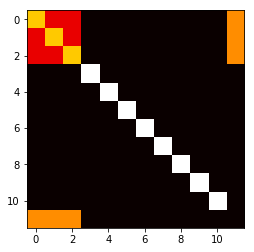

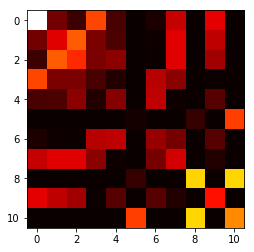

DEBUG:new iteration
value = -78.15982354365998, grad norm = 0.00016474040441662584, delta norm = 1.5227293646900713
hess values:
[  3.94e-04   3.89e-04   3.65e-04   1.42e-04  -1.40e-04   1.25e-04
  -1.21e-04   9.30e-05  -5.47e-05  -3.95e-05   3.92e-05]
DEBUG:new iteration
value = -78.15982354365998, grad norm = 0.00016474040441662584, delta norm = 1.5227293646900713
DEBUG:delta norm = 1.5227293646900713, expected = -0.00031851637862372354, real = -3.163548653617454e-05, d = 0.9006786191879105


GaussianException: 

In [4]:
MAX_R = .05
# random.seed(19)
known_directions = []

for i in range(10):
    seed = random.randint(0, 2**30)
    np.random.seed(seed)
    print('RANDOM SEED = {}'.format(seed))

    #     dir = np.array([1, -1, .3])
    dir = np.random.randn(normalized.n_dims)
    dir = linalg.eye(normalized.n_dims, 0) + linalg.eye(normalized.n_dims, 1) + linalg.eye(normalized.n_dims, 2)
    dir = dir / np.linalg.norm(dir) * MAX_R
    
    path = optimization.optimize_on_sphere_rfo(normalized, MAX_R, dir, 
                                                         delta_strategies.RFO(0), 
                                                         stop_strategies.GradNorm(1e-8))

    dir = path[-1]
    flag = True
    for known_dir in known_directions:
        dot = known_dir.dot(dir) / np.linalg.norm(known_dir) / np.linalg.norm(dir)
        if dot > .99:
            print('KNOWN DIRECTION: angle = {}, dot = {}'.format(acos(dot), dot))
            flag = False
            break
        else:
            print('from previous: angle = {}, dot = {}'.format(acos(dot), dot))
    if flag:
        known_directions.append(dir)
        
print()
print('Found directions:')
for dir in known_directions:
    print(dir)     

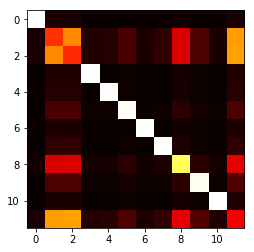

0, -1, 7.420014299545929


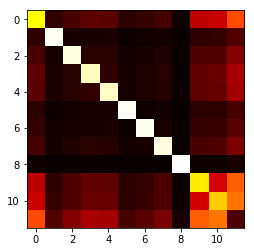

0, 1, 5.870719952670971


In [10]:
def test_function_hess(func, x):
    hess = np.zeros((func.n_dims, func.n_dims))
    delta = 1e-2
    for i in range(func.n_dims):
        for j in range(i, func.n_dims):
            e1 = delta * linalg.eye(func.n_dims, i)
            e2 = delta * linalg.eye(func.n_dims, j)

            val = .25 * (func(x + e1 + e2) - func(x - e1 + e2) - func(x + e1 - e2) + func(x - e1 - e2)) / delta ** 2
            print(val)
            hess[i, j] = hess[j, i] = val
    return hess

rfo = delta_strategies.RFO(0)
phi = np.zeros(normalized.n_dims - 1)

for axis in range(normalized.n_dims):
    for sign in [-1, 1]:
        dir = sign * linalg.eye(normalized.n_dims, axis)
        dir = np.random.randn(normalized.n_dims)
        
        in_polar = functions.PolarCoordsWithDirection(normalized, .05, dir)
        value, grad, hess = in_polar.value_grad_hess(phi)
        delta = rfo(val=value, grad=grad, hess=hess)
        
        print('{}, {}, {}'.format(axis, sign, np.linalg.norm(delta)))
    break


In [12]:
N = 1
for i, dir in enumerate(known_directions[N:N + 1]):
    path = modules.shs.shs(normalized, dir, MAX_R, MAX_R / 2)

#     axs = plot_all_spheres(vects, values, figsize=(50, 50), n_grid=1000, is_contour=True)
#     plot_path(axs, path)
#     plt.show()
    
    path = list(map(lambda struct: normalized.transform(struct), path))
    molecule.save_chemcraft_path('path_{}.xyz'.format(i), path)



Iteration 0: r = 0.05. Sphere optimization started:
new iteration
value = -78.15988875987904, grad norm = 4.522044908635918e-09, delta norm = 1.3760099863927212e-05
Sphere optimization returned path of length 1


Iteration 1: r = 0.07500000000000001. Sphere optimization started:
new iteration
value = -78.15853554133248, grad norm = 6.082460636867923e-05, delta norm = 0.022496827479393827
delta norm = 0.022496827479393827
expected = -6.678687390436169e-07, real = -6.655797761823123e-07, d = 0.0034272645618693373

new iteration
value = -78.1585362069122, grad norm = 2.754701253151868e-07, delta norm = 0.0002953430062159709
delta norm = 0.0002953430062159709
expected = -2.917725277878606e-11, real = -2.944489096989855e-11, d = 0.009172837248991516

new iteration
value = -78.15853620694155, grad norm = 5.704363164829529e-11, delta norm = 8.817764130442788e-08
Sphere optimization returned path of length 3


Iteration 2: r = 0.1. Sphere optimization started:
new iteration
value = -78.15674

new iteration
value = -78.12448186316033, grad norm = 9.131107672519347e-05, delta norm = 0.00038178650183382597
delta norm = 0.00038178650183382597
expected = -1.3693692481574226e-08, real = -1.3696421774511691e-08, d = 0.0001993102255756093

new iteration
value = -78.12448187685699, grad norm = 3.064376535263941e-08, delta norm = 1.7720146180363487e-07
Sphere optimization returned path of length 3


Iteration 13: r = 0.37500000000000006. Sphere optimization started:
new iteration
value = -78.12040917521064, grad norm = 0.006243513884814651, delta norm = 0.015865731088879224
delta norm = 0.015865731088879224
expected = -4.9093709876600684e-05, real = -4.847744277469701e-05, d = 0.012552872933267612

new iteration
value = -78.12045765265353, grad norm = 0.00011622615637645514, delta norm = 0.00038529435733522115
delta norm = 0.00038529435733522115
expected = -1.777528974226848e-08, real = -1.77789871713685e-08, d = 0.0002080094982208481

new iteration
value = -78.12045767043243, grad n

delta norm = 0.16360711272393838
expected = -1.1221291686736725e-05, real = -1.2969323265110688e-05, d = 0.1557781071175693

new iteration
value = -78.10795015835623, grad norm = 0.008321622162900022, delta norm = 0.06797671549618917
delta norm = 0.06797671549618917
expected = -5.565441131369846e-05, real = -5.241249657217395e-05, d = 0.05825081363723926

new iteration
value = -78.10800257085235, grad norm = 0.0006080239328140471, delta norm = 0.12342602905788955
delta norm = 0.12342602905788955
expected = -8.655689925537058e-07, real = 6.482583657430041e-06, d = 8.489389884802067

delta norm = 0.06171301452894477
expected = -6.426826430829984e-07, real = 3.392409553271136e-08, d = 1.0527851434885107

delta norm = 0.030856507264472387
expected = -3.738158582430355e-07, real = -3.0490377866954077e-07, d = 0.18434766223505616

new iteration
value = -78.10800287575634, grad norm = 0.00046939886689106164, delta norm = 0.006235741520619021
delta norm = 0.006235741520619021
expected = -3.777

delta norm = 0.012787104257780981
expected = -1.9156304053061863e-06, real = -1.9894267495601525e-06, d = 0.038523268397470924

new iteration
value = -78.08661418296526, grad norm = 3.665554302710914e-05, delta norm = 0.0011287630114524807
delta norm = 0.0011287630114524807
expected = -9.244861910575906e-09, real = -9.285713531426154e-09, d = 0.0044188459757862454

new iteration
value = -78.08661419225083, grad norm = 1.6735068685124003e-07, delta norm = 7.831658028383844e-06
delta norm = 7.831658028383844e-06
expected = -4.3025627427828744e-13, real = -7.105427357601002e-13, d = 0.6514407301833441

new iteration
value = -78.08661419225118, grad norm = 1.7351135934662398e-10, delta norm = 2.9923840325815127e-09
Sphere optimization returned path of length 5


Iteration 22: r = 0.6000000000000002. Sphere optimization started:
new iteration
value = -78.08221102597423, grad norm = 0.01816946444187862, delta norm = 0.0354708078784062
delta norm = 0.0354708078784062
expected = -0.00011446451



Iteration 30: r = 0.8000000000000004. Sphere optimization started:
new iteration
value = -78.04892728107026, grad norm = 0.027713374083984835, delta norm = 0.02120208133026826
delta norm = 0.02120208133026826
expected = -0.0001415591406831306, real = -0.00013760040798160844, d = 0.02796522133730295

new iteration
value = -78.04906488147824, grad norm = 0.0011036367911224237, delta norm = 0.001910114696182225
delta norm = 0.001910114696182225
expected = -4.736783145773761e-07, real = -4.7466892283409834e-07, d = 0.0020913101280688145

new iteration
value = -78.04906535614731, grad norm = 4.331004468010155e-06, delta norm = 1.951574519469207e-05
delta norm = 1.951574519469207e-05
expected = -1.8702588406787765e-11, real = -1.850253283919301e-11, d = 0.010696678087731965

new iteration
value = -78.04906535616578, grad norm = 2.9751701505588826e-10, delta norm = 1.9497423630583954e-09
Sphere optimization returned path of length 4


Iteration 31: r = 0.8250000000000004. Sphere optimizatio

In [14]:
molecule.save_chemcraft_path('path_1234.xyz', path)

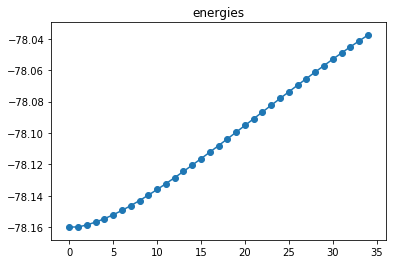

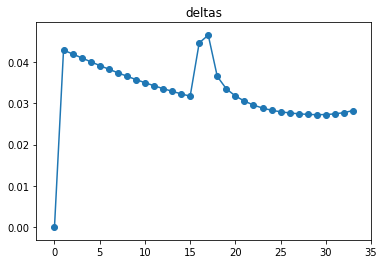

/home/george/envs/ml/lib/python3.5/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


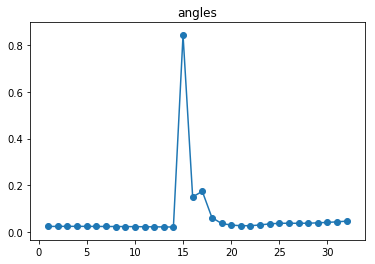

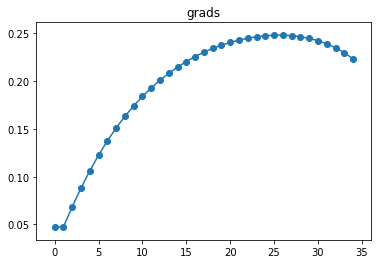

In [13]:
energies = [molecule(struct) for struct in path]
plt.plot(energies)
plt.scatter(np.arange(len(energies)), energies)
plt.title('energies')
plt.show()

deltas = [np.linalg.norm(struct1 - struct2) for struct1, struct2 in zip(path, path[1:])]
plt.plot(deltas)
plt.scatter(np.arange(len(deltas)), deltas)
plt.title('deltas')
plt.show()

angles = [acos((s3 - s2).dot(s2 - s1) / np.linalg.norm(s3 - s2) / np.linalg.norm(s2 - s1)) 
                    for s1, s2, s3 in zip(path, path[1:], path[2:])]
plt.plot(angles)
plt.scatter(np.arange(len(angles)), angles)
plt.title('angles')
plt.show()

grads = [np.linalg.norm(molecule.grad(struct)) for struct in path]
plt.plot(grads)
plt.scatter(np.arange(len(grads)), grads)
plt.title('grads')
plt.show()

In [71]:
zeros = np.zeros(molecule.n_dims - 6)
for i, struct in enumerate(path):
    hess = linalg.get_motionless(molecule, struct).hess(zeros)
    print(i, linalg.calc_singular_values(hess))

0 [ 5.4   3.7   3.23  2.24  1.16  0.67  0.55  0.52  0.32  0.3   0.15  0.11]
1 [ 5.4   3.7   3.23  2.24  1.16  0.67  0.55  0.52  0.32  0.3   0.15  0.11]
2 [ 5.42  3.75  3.27  2.29  1.17  0.66  0.55  0.52  0.32  0.3   0.15  0.11]
3 [ 5.45  3.79  3.29  2.33  1.18  0.65  0.55  0.51  0.31  0.3   0.14  0.1 ]
4 [ 5.49  3.83  3.29  2.37  1.19  0.65  0.55  0.51  0.31  0.3   0.14  0.1 ]
5 [ 5.53  3.85  3.29  2.41  1.2   0.64  0.55  0.5   0.31  0.29  0.13  0.09]
6 [ 5.57  3.87  3.27  2.44  1.21  0.63  0.56  0.49  0.31  0.29  0.13  0.09]
7 [ 5.61  3.88  3.25  2.47  1.21  0.63  0.56  0.49  0.32  0.28  0.13  0.09]
8 [ 5.64  3.88  3.23  2.5   1.21  0.62  0.56  0.48  0.33  0.28  0.12  0.09]
9 [ 5.68  3.88  3.2   2.52  1.21  0.62  0.56  0.47  0.33  0.28  0.12  0.09]
10 [ 5.71  3.87  3.16  2.54  1.21  0.62  0.56  0.47  0.34  0.27  0.12  0.09]
11 [ 5.73  3.86  3.13  2.55  1.21  0.61  0.56  0.46  0.35  0.27  0.11  0.09]
12 [ 5.76  3.85  3.09  2.56  1.2   0.61  0.56  0.45  0.35  0.27  0.11  0.09]
13 [ 5.78

In [87]:
zeros = np.zeros(molecule.n_dims - 6)
for i, struct in enumerate(path):
    hess = normalized.hess(normalized.back_transform(struct))
    print(i, linalg.calc_singular_values(hess))

0 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


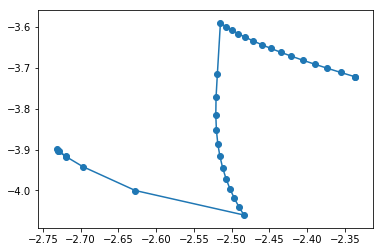

In [68]:
projection = utils.linalg.RandomProjector(molecule.n_dims, 2)

xs, ys = [], []
for struct in path:
    x, y = projection.project(struct)
    xs.append(x)
    ys.append(y)
    
plt.plot(xs, ys)
plt.scatter(xs, ys)